In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(
    rc={"figure.figsize": (14, 6), "figure.dpi": 80},
    font_scale=1.1,
    style="ticks",
    palette="colorblind",
)

Cria uma conta no kaggle, configure o API Token conforme a documentação, e execute o script abaixo.

In [2]:
# Descomente a linha abaixo caso deseje fazer o download dos dados diretamente do kaggle
# !kaggle competitions download -c store-sales-time-series-forecasting

In [3]:
import zipfile
with zipfile.ZipFile("store-sales-time-series-forecasting.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

In [4]:
!ls ./dataset

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv		     stores.csv		    train.csv


Conjunto de treinamento
------------------------------------


The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.


In [5]:
train = pd.read_csv("./dataset/train.csv", parse_dates=["date"])
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

In [6]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [7]:
sales = train.pivot(index="date", columns=["store_nbr", "family"], values="sales")
onpromotion = train.pivot(index="date", columns=["store_nbr", "family"], values="onpromotion")

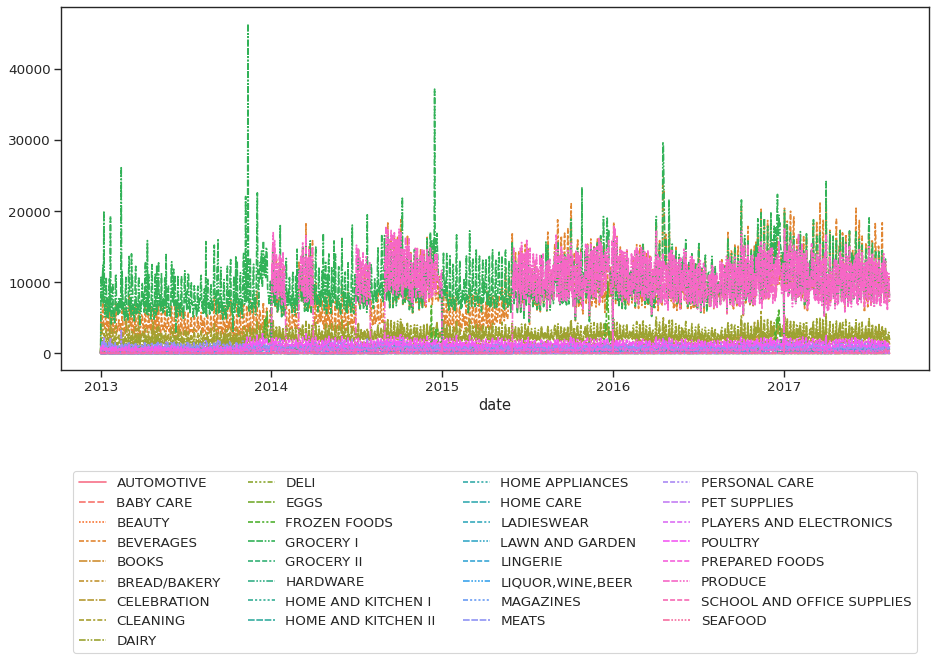

In [8]:
sns.lineplot(data=sales[44])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.8))

<AxesSubplot:xlabel='date'>

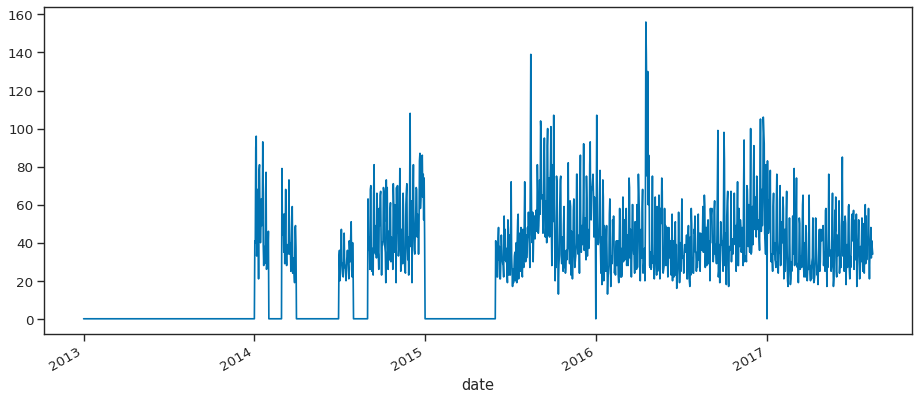

In [9]:
sales[44]["PLAYERS AND ELECTRONICS"].plot()

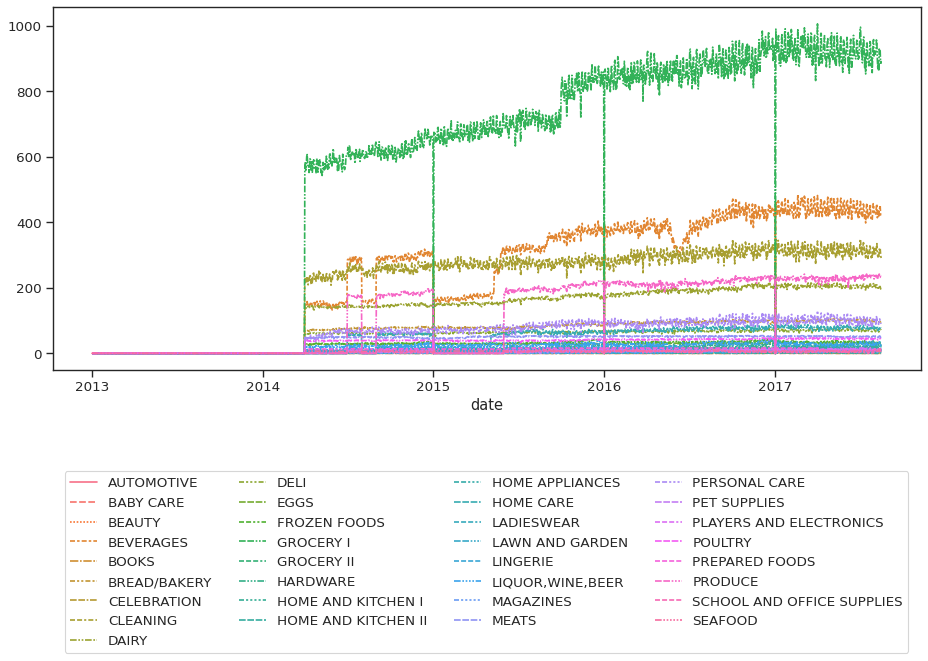

In [10]:
sns.lineplot(data=onpromotion[44])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.8))

<AxesSubplot:xlabel='date'>

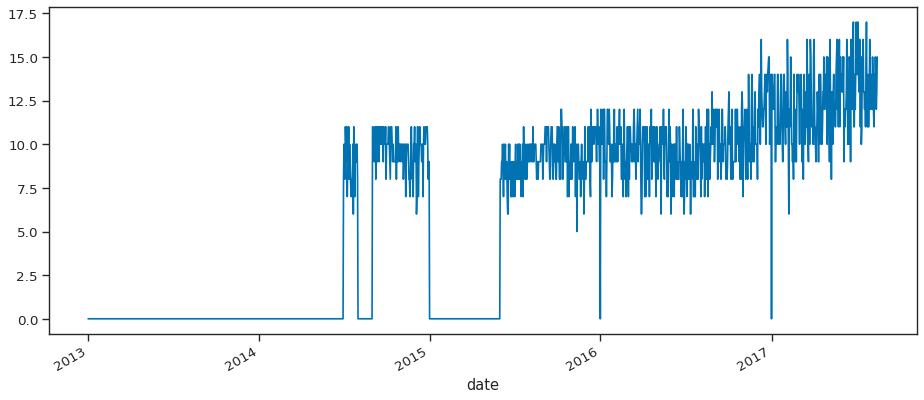

In [11]:
onpromotion[44]["PLAYERS AND ELECTRONICS"].plot()

<AxesSubplot:xlabel='date'>

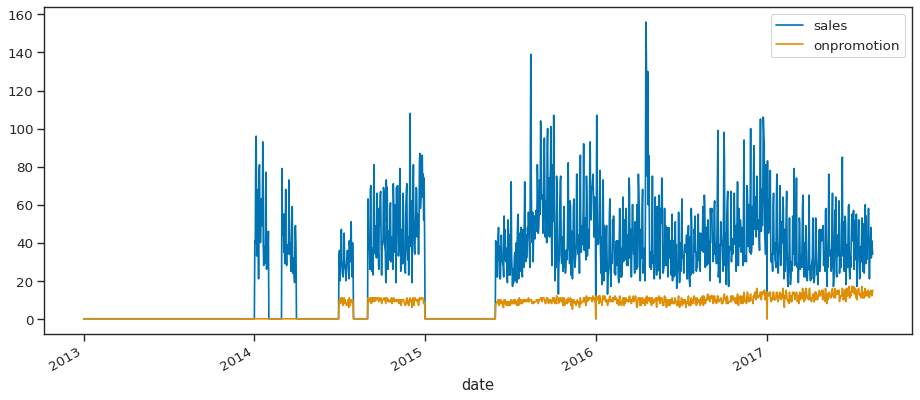

In [12]:
electronics = train.query("store_nbr == 44 & family == 'PLAYERS AND ELECTRONICS'")
electronics = electronics.set_index("date")[["sales", "onpromotion"]]
electronics.plot()

Carregando a tabela de feriados
----------------------------------------------

Eventos e feriados


KAGGLE NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


In [13]:
# prophet (Facebook)
holidays = pd.read_csv("./dataset/holidays_events.csv", parse_dates=["date"])
holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

Preço Óleo
----------------

Preço diário do óleo. Inclui as datas do conjuntos de treinamento e de teste.
Obs.: O Ecuador é um país dependente de óleo e sua saúde econômica é vulnerável a mudanças no comportamento do preço do óleo no mercado.

In [14]:
oil = pd.read_csv("./dataset/oil.csv", parse_dates=["date"])
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

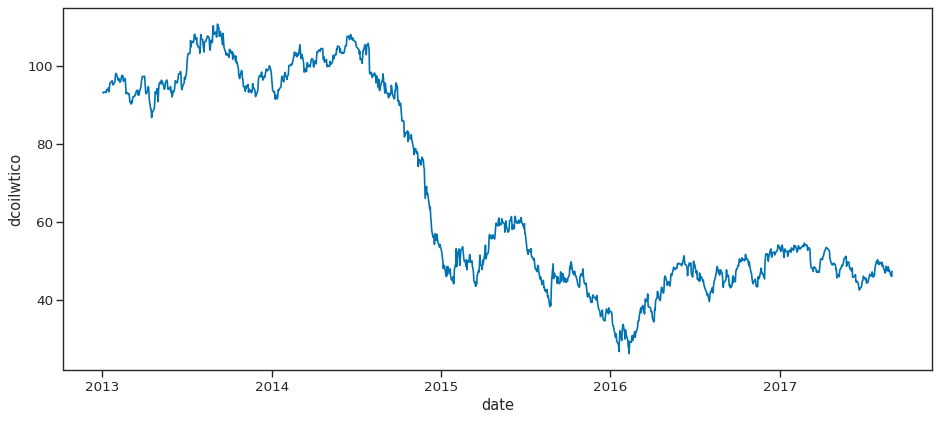

In [15]:
fig, axes = plt.subplots(nrows=1, figsize=(14, 6))
sns.set_theme(style="ticks")
sns.lineplot(x=oil.date, y=oil.dcoilwtico)

É possível observar que a variação do preço do óleo parece seguir um processo de passeio aleatório e, consequentemente, não estacionário. Vamos verificar, repectivamente, a ACF e a PACF da série.

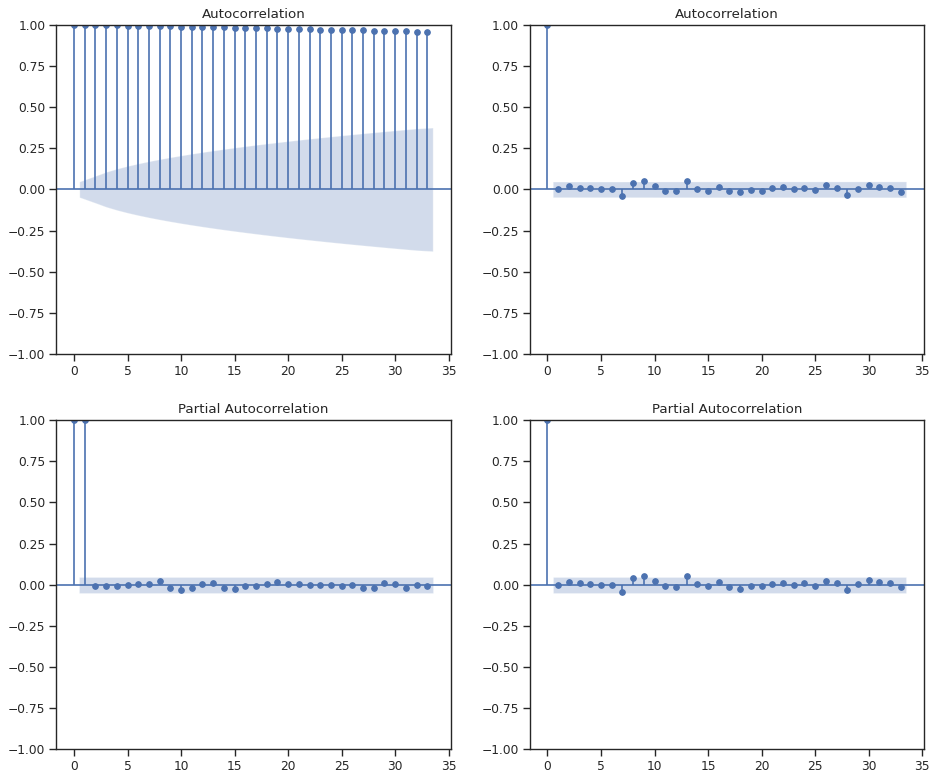

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_date_oil = oil.copy().set_index("date").asfreq("D").interpolate(method="time").dropna()
df_date_oil_diff = df_date_oil.diff().dropna()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
plot_acf(x=df_date_oil, ax=axes[0][0]);
plot_pacf(x=df_date_oil, ax=axes[1][0], method="ywm");

plot_acf(x=df_date_oil_diff, ax=axes[0][1]);
plot_pacf(x=df_date_oil_diff, ax=axes[1][1], method="ywm");

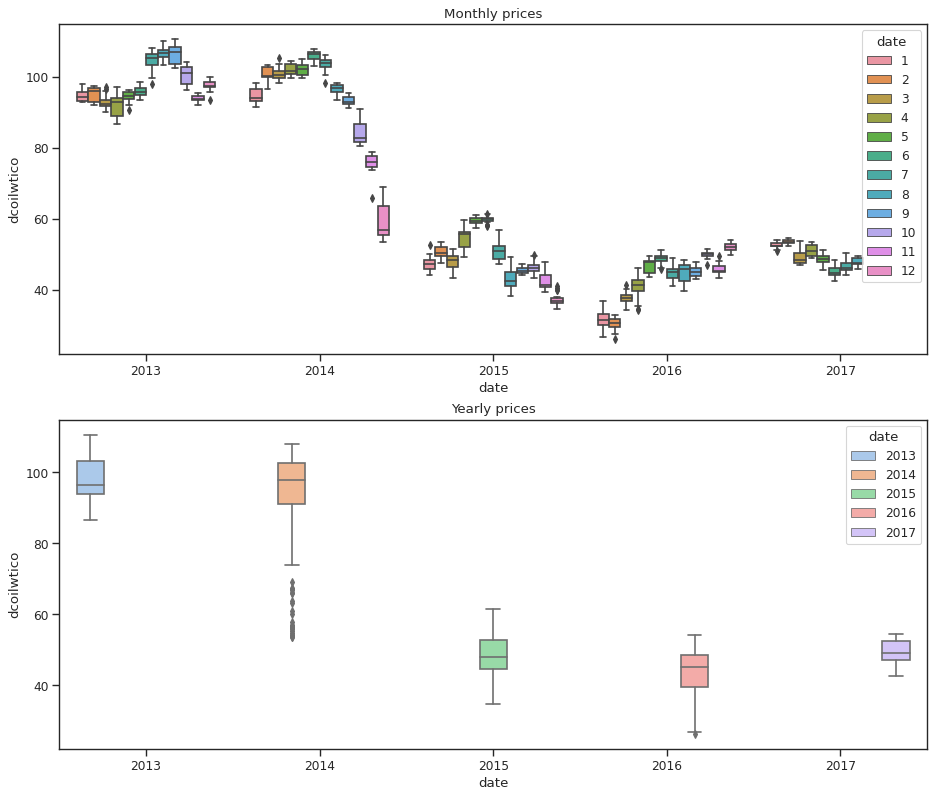

In [17]:
def plot_boxplot(x, y, hue, ax, title):
    sns.set_theme(style="ticks", palette="pastel")
    ax = sns.boxplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

plot_boxplot(x=oil["date"].dt.year,
             y=oil["dcoilwtico"],
             hue=oil["date"].dt.month,
             ax=axes[0],
             title="Monthly prices")

plot_boxplot(x=oil["date"].dt.year,
             y=oil["dcoilwtico"],
             hue=oil["date"].dt.year,
             ax=axes[1],
             title="Yearly prices")

In [18]:
stores = pd.read_csv("./dataset/stores.csv")
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [19]:
transactions = pd.read_csv("./dataset/transactions.csv", parse_dates=["date"])
transactions

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

<AxesSubplot:xlabel='store_nbr'>

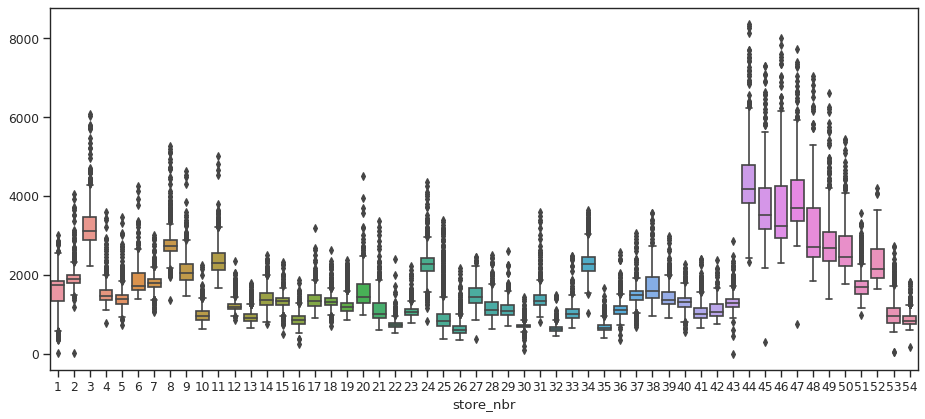

In [20]:
trans_per_store = transactions.pivot(index="date", columns="store_nbr", values="transactions")
sns.boxplot(data=trans_per_store)

<AxesSubplot:xlabel='date'>

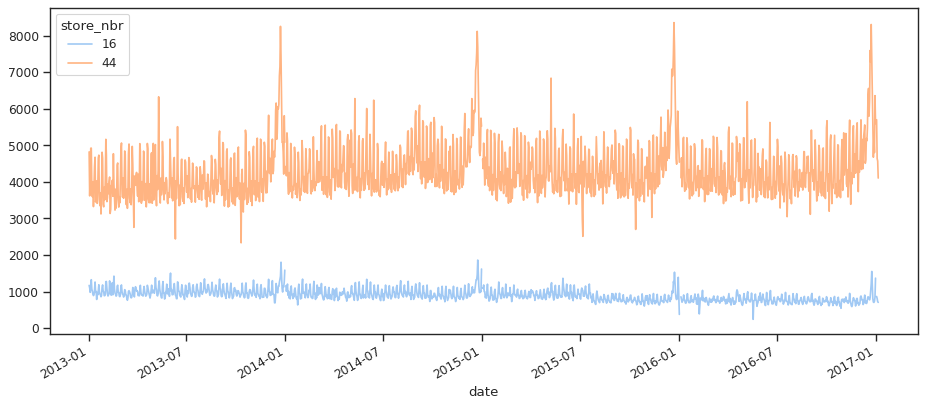

In [21]:
trans_per_store[[16,44]].iloc[:365*4].plot()

In [22]:
import numpy as np

def weighted_mean(signal, window):
    if len(window) % 2 != 1:
        raise ValueError("Window must be odd")
    slen = len(signal)
    wlen = len(window)
    mlen = int(slen - wlen + 1)
    mean = np.zeros(mlen)
    for pivot in range(mlen):
        spart = signal[pivot:pivot + wlen]
        mean[pivot] = sum(spart * window) / sum(window)

    return mean

def weighted_stats(signal, window):
    if len(window) % 2 != 1:
        raise ValueError("Window must be odd")
    slen = len(signal)
    wlen = len(window)
    mlen = int(slen - wlen + 1)
    mean = weighted_mean(signal, window)
    var = np.zeros_like(mean)
    
    for pivot in range(mlen):
        spart = (signal[pivot:pivot + wlen] - mean[pivot]) ** 2
        var[pivot] =  sum(spart * window) / sum(window)

    return mean, var

<StemContainer object of 3 artists>

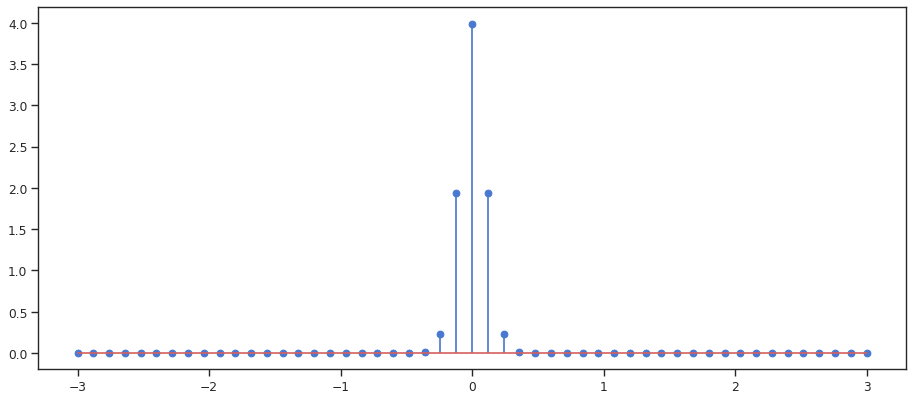

In [43]:
from scipy.stats import norm

def gaussian_window(size, sigma2=1):
    dist = norm(0, sigma2)
    points = np.linspace(-3, 3, size)
    return points, dist.pdf(points)

p, d = gaussian_window(51, sigma2=0.1)
plt.stem(p, d)

<AxesSubplot:>

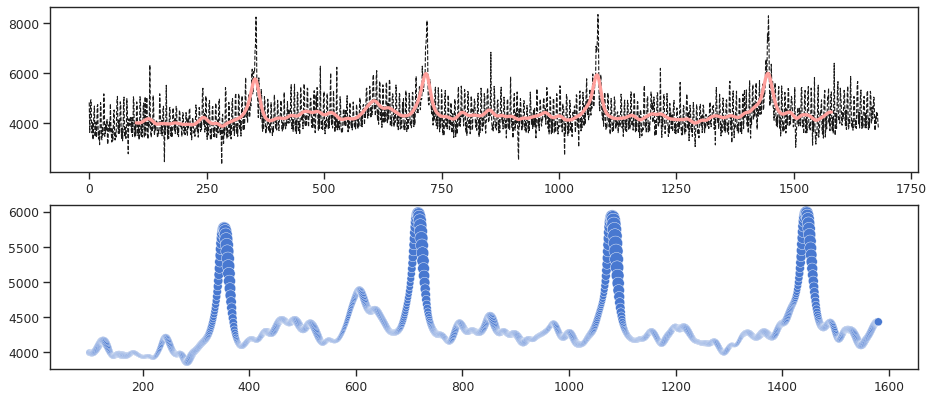

In [44]:
values = trans_per_store[44].interpolate('time').dropna().values

wsize = 201
vmean, vvar = weighted_stats(values, gaussian_window(wsize, sigma2=0.2)[1])
time = np.arange(len(values))

plt.subplot(211);
plt.plot(time, values, 'k--', lw=1)
plt.plot(time[(wsize - 1)//2:-(wsize - 1)//2], vmean,  'r', lw=3)

plt.subplot(212);
sns.scatterplot(x=time[(wsize - 1)//2:-(wsize - 1)//2], y=vmean, s=vvar/10000)

In [47]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from collections import defaultdict

class TimeSeriesKMedoids:
    def __init__(self, n_clusters=3, metric='euclidean'):
        self.n_clusters = n_clusters
        self.metric = metric
        
    def fit_predict(self, X):
        n, m = X.shape

        D = np.zeros((n, n))
        for i in range(n):
            for j in range(1, n):
                if i != j:
                    D[i, j] = D[j, i] = self._distance(X[i, :], X[j, :])
                
        indexes = [i for i in range(n)]
        np.random.shuffle(indexes)
        medoids = indexes[:self.n_clusters]
            
        for _iter in range(20):
            # Classify series
            classes = [(-1, float('inf')) for _ in range(n)]
            for i in range(n):
                for j in range(self.n_clusters):
                    d = D[medoids[j], i]
                    if d < classes[i][1]:
                        classes[i] = (j, d)

            members = defaultdict(list)
            for i, (j, _) in enumerate(classes):
                members[j].append(i)

            # Update medoids
            for i in range(self.n_clusters):
                cost = float('inf')
                indx = -1

                for j in members[i]:
                    p_cost = sum([D[j, k] for k in members[i]])
                    if p_cost < cost:
                        cost = p_cost
                        indx = j

                medoids[i] = indx
            
        self.cluster_medoids_ = X[medoids, :]
        
        classes = [(-1, float('inf')) for _ in range(n)]
        for i in range(n):
            for j in range(self.n_clusters):
                d = D[medoids[j], i]
                if d < classes[i][1]:
                    classes[i] = (j, d)
            
        return np.array([c for (c, _) in classes])
    
    def fit(self, X):
        self.fit_predict(X)
        return self
    
    def _distance(self, a, b):
        if self.metric == 'euclidean':
            return euclidean(a, b)
        if self.metric == 'dtw':
            d, _ = fastdtw(a, b, radius=10)
            return d
        raise ValueError(f"Unknown metric `{self.metric}`")

In [52]:
trans.T.head()

date       2013-05-09  2013-05-10  2013-05-11  2013-05-12  2013-05-13  \
store_nbr                                                               
1              1813.0      1959.0      1488.0       549.0      1784.0   
2              1732.0      1831.0      2308.0      1933.0      1724.0   
3              2875.0      3343.0      4326.0      3149.0      2820.0   
4              1379.0      1528.0      2086.0      1778.0      1411.0   
5              1318.0      1538.0      2158.0      1809.0      1469.0   

date       2013-05-14  2013-05-15  2013-05-16  2013-05-17  2013-05-18  ...  \
store_nbr                                                              ...   
1              1747.0      1887.0      1781.0      1883.0      1299.0  ...   
2              1721.0      1820.0      1736.0      1704.0      2005.0  ...   
3              2746.0      2896.0      2744.0      2974.0      3605.0  ...   
4              1331.0      1571.0      1306.0      1423.0      1708.0  ...   
5              1406.0      1447.0      1321.0      1442.0      1591.0  ...   

date       2017-08-06  2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr                                                               
1               507.0      1665.0      1766.0      1766.0      1764.0   
2              1905.0      1700.0      1688.0      1786.0      1695.0   
3              3506.0      3046.0      2835.0      2962.0      2841.0   
4              1453.0      1231.0      1222.0      1325.0      1281.0   
5              1140.0      1348.0      1183.0      1275.0      1262.0   

date       2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr                                                              
1               570.0      1004.0       416.0      1733.0      1693.0  
2              1698.0      1613.0      1658.0      1788.0      1737.0  
3              2991.0      3070.0      3075.0      3036.0      2956.0  
4              1301.0      1304.0      1378.0      1285.0      1283.0  
5              1183.0      1061.0      1098.0      1225.0      1310.0  

[5 rows x 1554 columns]

In [80]:
trans = trans_per_store.interpolate(method='time').dropna(axis=1, thresh=1500).backfill().dropna()
trans.T.head()

date       2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  \
store_nbr                                                               
1              2111.0      2111.0      1833.0      1863.0      1509.0   
2              2358.0      2358.0      2033.0      2066.0      2062.0   
3              3487.0      3487.0      3026.0      3188.0      3623.0   
4              1922.0      1922.0      1551.0      1596.0      1825.0   
5              1903.0      1903.0      1740.0      1642.0      1643.0   

date       2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  ...  \
store_nbr                                                              ...   
1               520.0      1807.0      1869.0      1910.0      1679.0  ...   
2              1992.0      1911.0      1856.0      1975.0      1761.0  ...   
3              3590.0      2996.0      2826.0      2932.0      2649.0  ...   
4              1891.0      1514.0      1397.0      1533.0      1326.0  ...   
5              1754.0      1577.0      1504.0      1513.0      1449.0  ...   

date       2017-08-06  2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr                                                               
1               507.0      1665.0      1766.0      1766.0      1764.0   
2              1905.0      1700.0      1688.0      1786.0      1695.0   
3              3506.0      3046.0      2835.0      2962.0      2841.0   
4              1453.0      1231.0      1222.0      1325.0      1281.0   
5              1140.0      1348.0      1183.0      1275.0      1262.0   

date       2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr                                                              
1               570.0      1004.0       416.0      1733.0      1693.0  
2              1698.0      1613.0      1658.0      1788.0      1737.0  
3              2991.0      3070.0      3075.0      3036.0      2956.0  
4              1301.0      1304.0      1378.0      1285.0      1283.0  
5              1183.0      1061.0      1098.0      1225.0      1310.0  

[5 rows x 1682 columns]

In [111]:
from tslearn.clustering import TimeSeriesKMeans

# trans = trans_per_store.interpolate(method='time').dropna(axis=1, thresh=1500).dropna()
trans = trans_per_store.interpolate(method="time").backfill()[:900]
# tsc = TimeSeriesKMeans(n_clusters=5, metric="dtw")
tsc = TimeSeriesKMedoids(n_clusters=10, metric="dtw")
classes = tsc.fit_predict(trans.T.values)

In [112]:
from collections import defaultdict

store_class = {
    trans.columns[i]: classes[i]
    for i in range(len(classes))
}

class_store = defaultdict(list)
for store, cls in store_class.items():
    class_store[cls].append(store)
class_store

defaultdict(list,
            {4: [1],
             3: [2, 6, 7, 38, 42, 51],
             1: [3, 21, 44, 45, 46, 47, 48, 52],
             2: [4, 5, 14, 37, 39, 53],
             9: [8, 9, 11, 22, 24, 29, 34, 49, 50],
             8: [10, 13, 16, 23, 36, 41, 54],
             6: [12, 15, 17, 18, 19, 28, 31, 33, 40, 43],
             0: [20],
             7: [25, 26, 30, 32, 35],
             5: [27]})

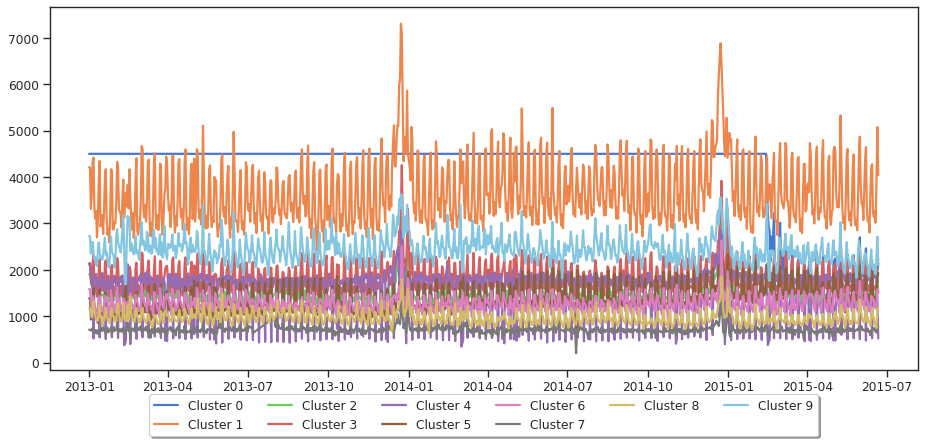

In [113]:
sns.set_palette("muted")

for cls in sorted(class_store.keys()):
    if isinstance(tsc, TimeSeriesKMedoids):
        serie = pd.Series(tsc.cluster_medoids_[cls].ravel(), index=trans.index)
    else:
        serie = pd.Series(tsc.cluster_centers_[cls].ravel(), index=trans.index)
    plt.plot(serie, lw=2)

plt.legend([f"Cluster {c}" for c in sorted(class_store.keys())],
           loc="lower center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=6);

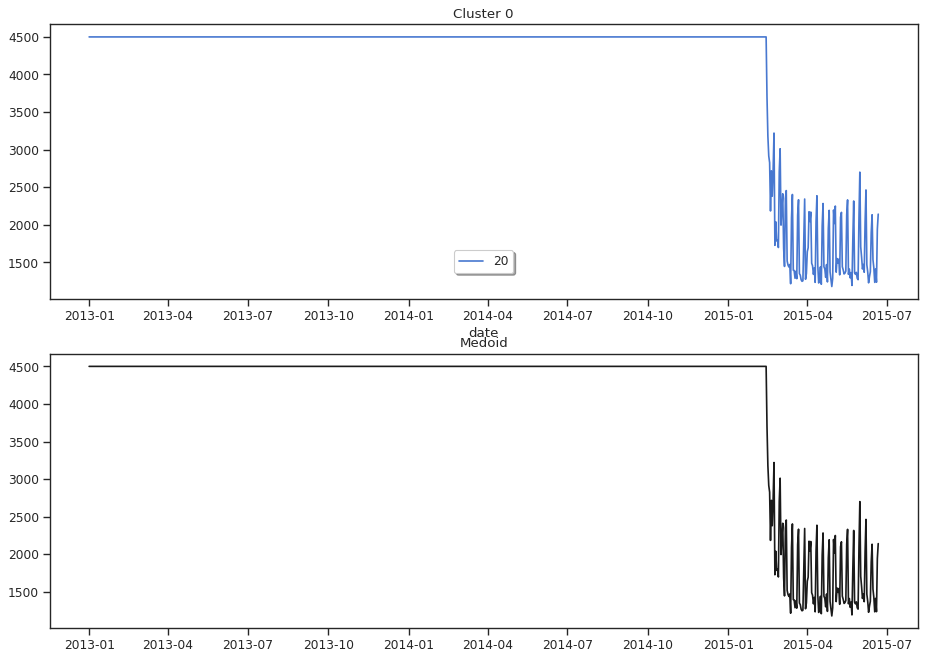

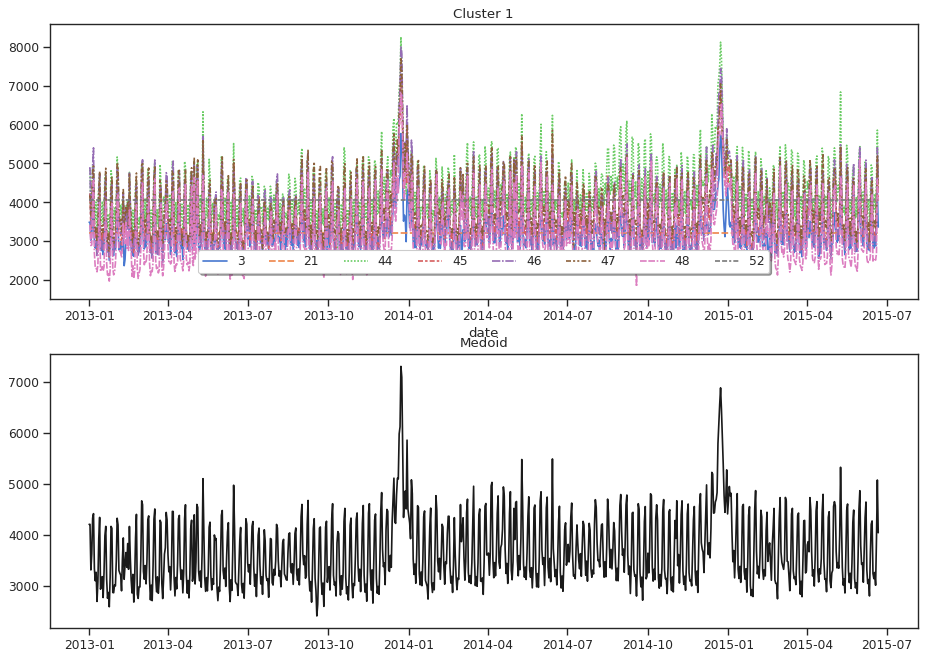

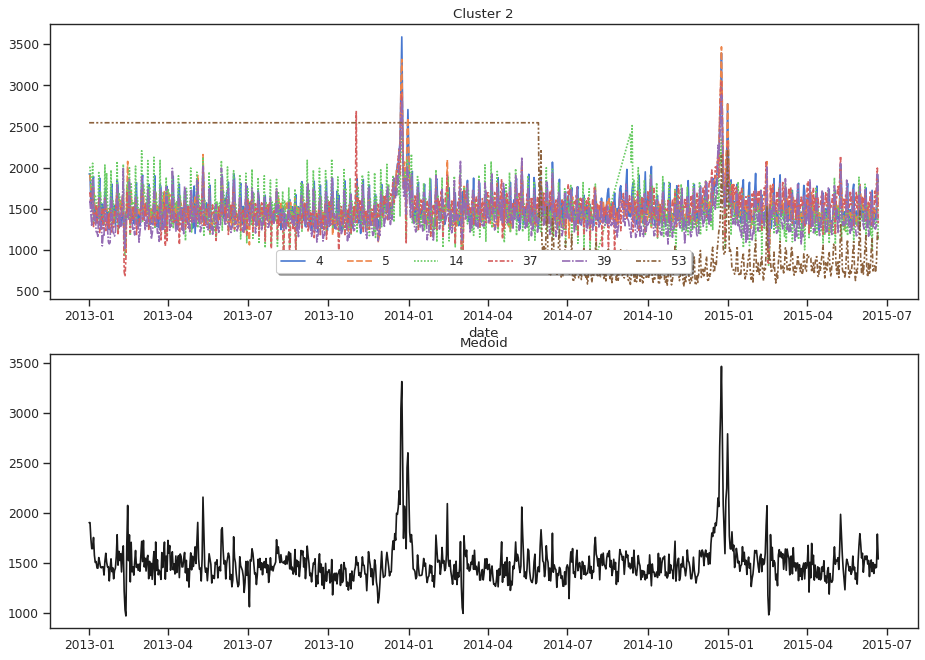

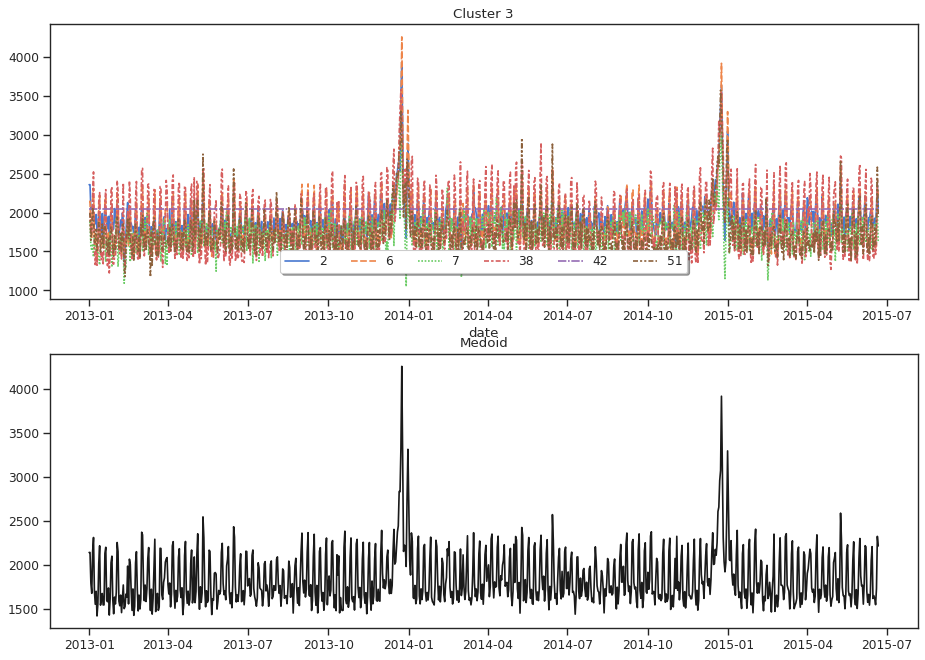

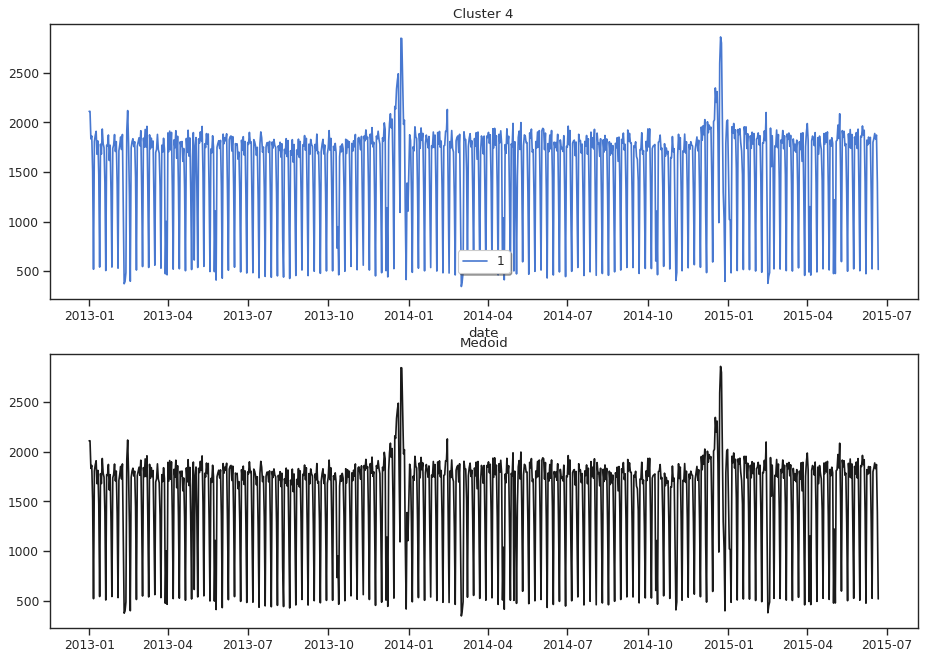

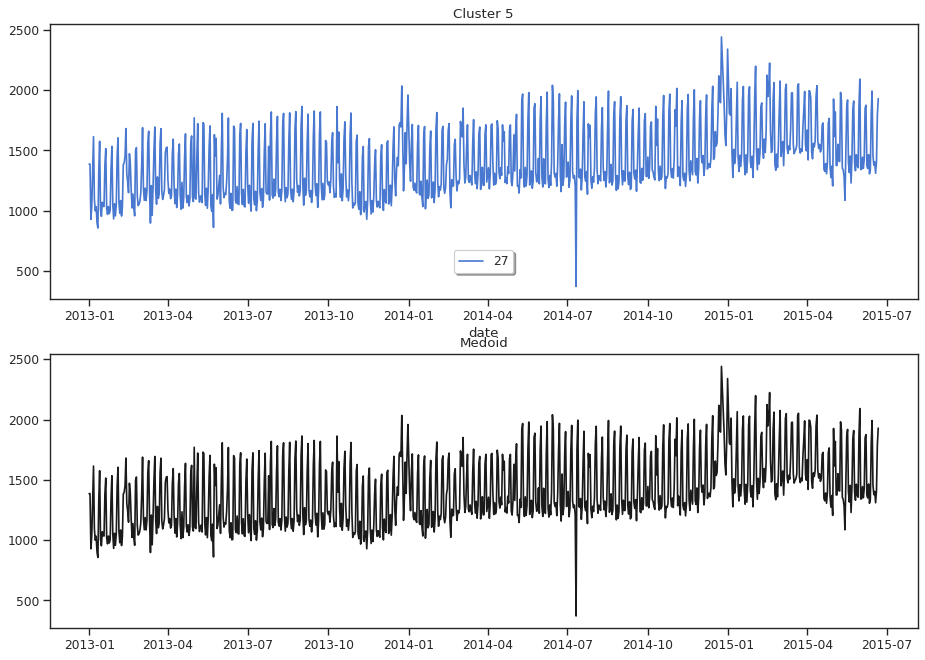

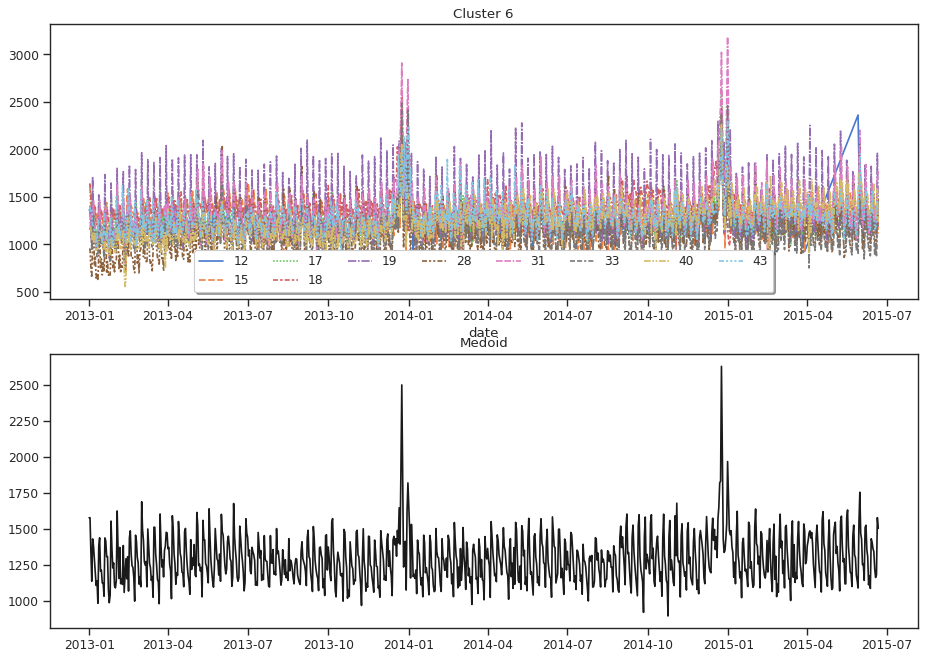

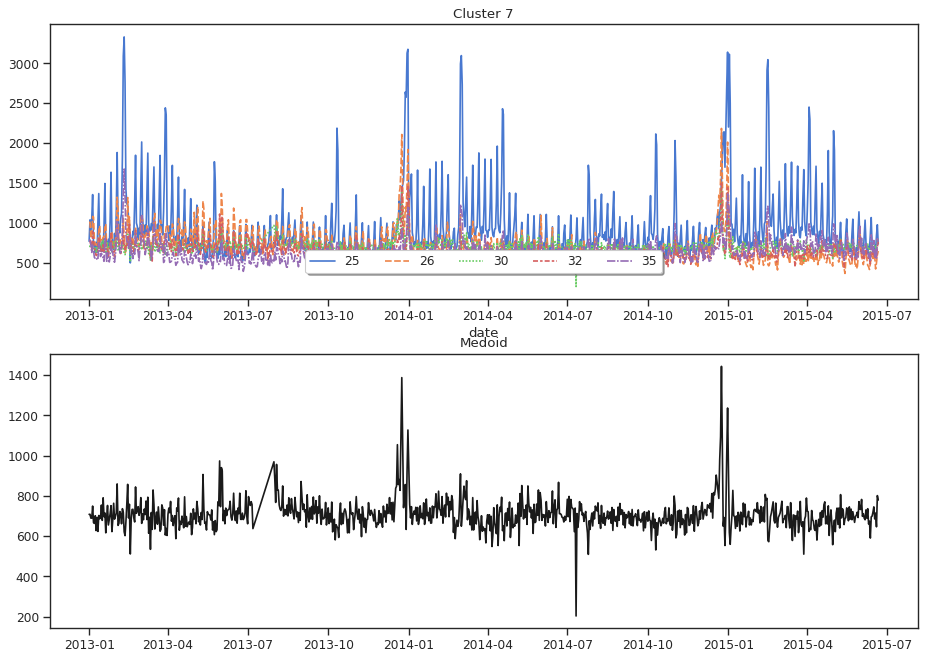

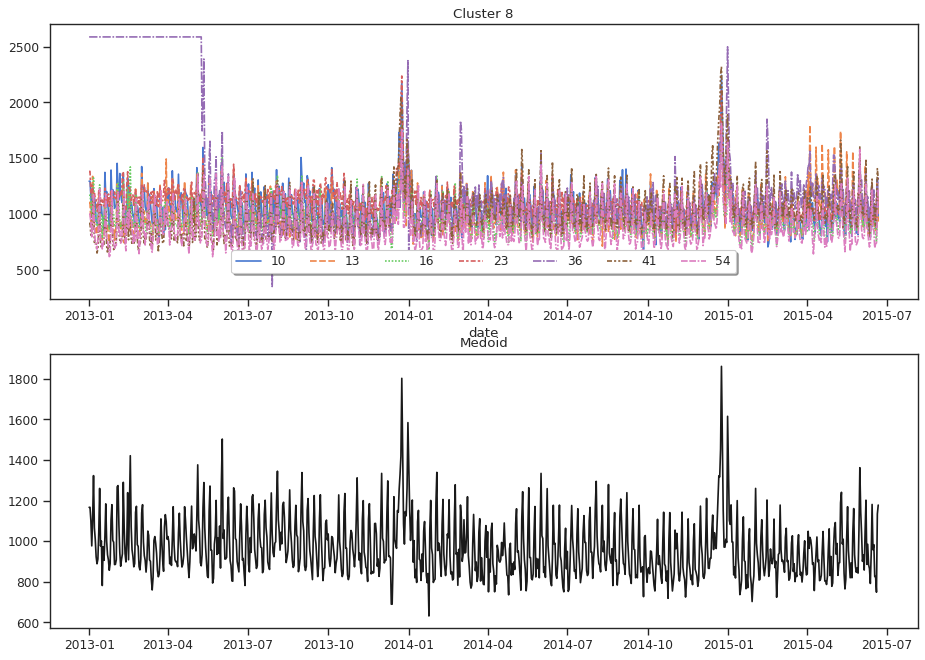

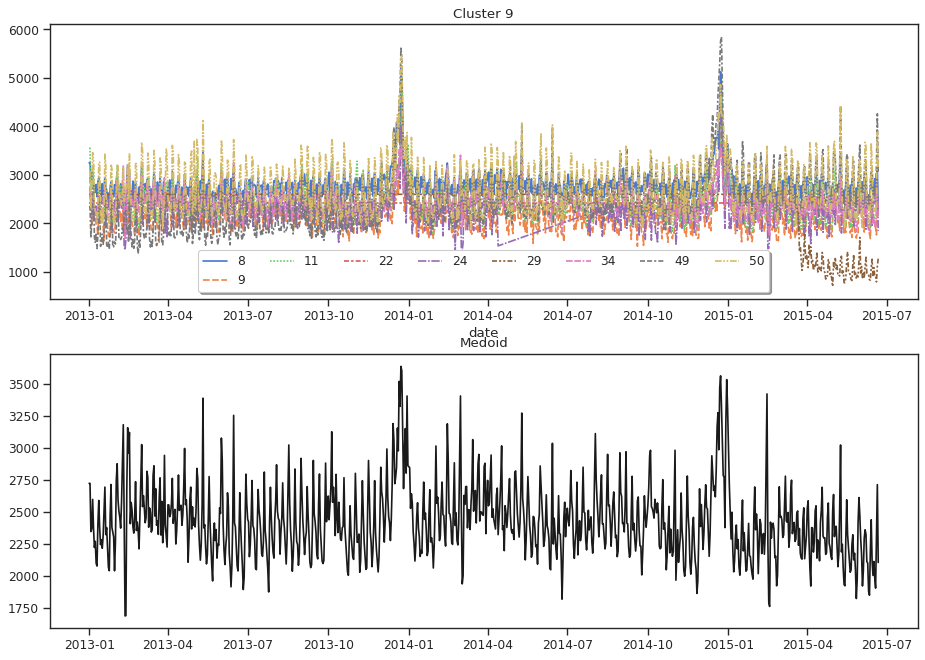

In [114]:
for cls, stores in sorted(class_store.items()):
    plt.figure(figsize=(14, 10))
    plt.subplot(211)
    data = trans[stores]
    sns.lineplot(data=data)
    plt.title(f"Cluster {cls}")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 0.2), ncol=8, shadow=True)

    if isinstance(tsc, TimeSeriesKMedoids):
        serie = pd.Series(tsc.cluster_medoids_[cls].ravel(), index=trans.index)
    else:
        serie = pd.Series(tsc.cluster_centers_[cls].ravel(), index=trans.index)
    
    plt.subplot(212)
    plt.plot(serie, 'k')
    plt.title("Medoid")

Dynamic Time Warping - Visualização
------------------------------------------------------

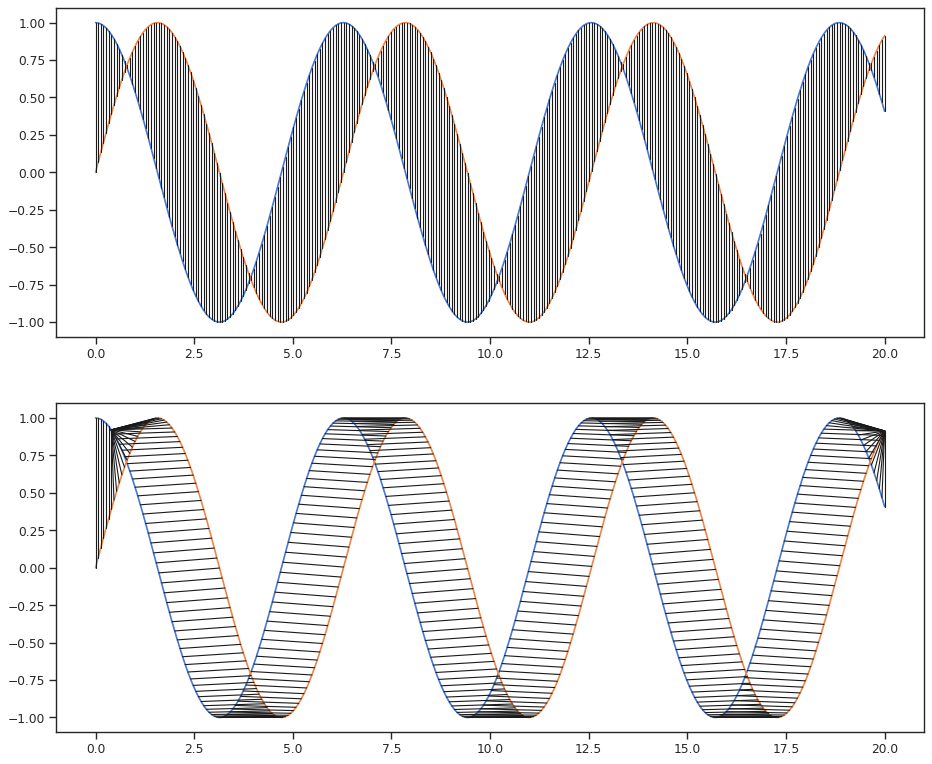

In [30]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, cdist

t = np.linspace(0, 20, 300)
x = np.cos(t)
y = np.sin(t)

distance, path = fastdtw(x, y, dist=euclidean)
d, _ = fastdtw(y, x, dist=euclidean)

fig, axes = plt.subplots(nrows=2, figsize=(14, 12))

axes[0].plot(t, x)
axes[0].plot(t, y)

for i, _t in enumerate(t):
    axes[0].plot([_t, _t], [x[i], y[i]], 'k', lw=1)


axes[1].plot(t, x)
axes[1].plot(t, y)

for _from, _to in path:
    axes[1].plot(
        [t[_from], t[_to]],
        [x[_from], y[_to]], 
        'k', 
        lw=1
    )

Text(0.5, 0, 'Time')

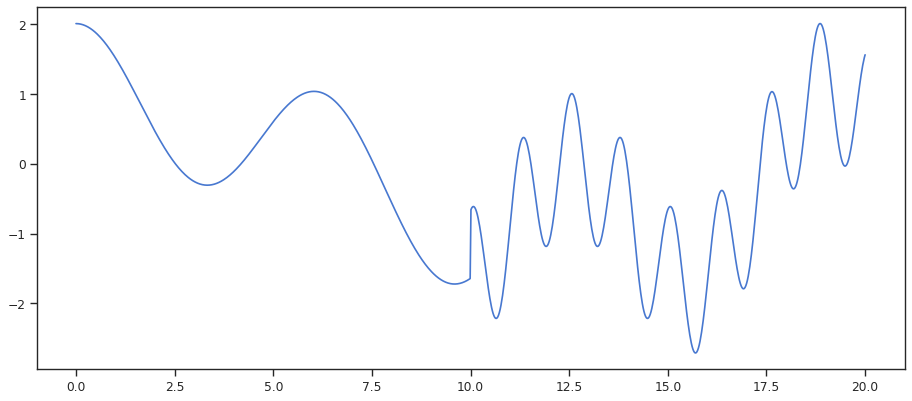

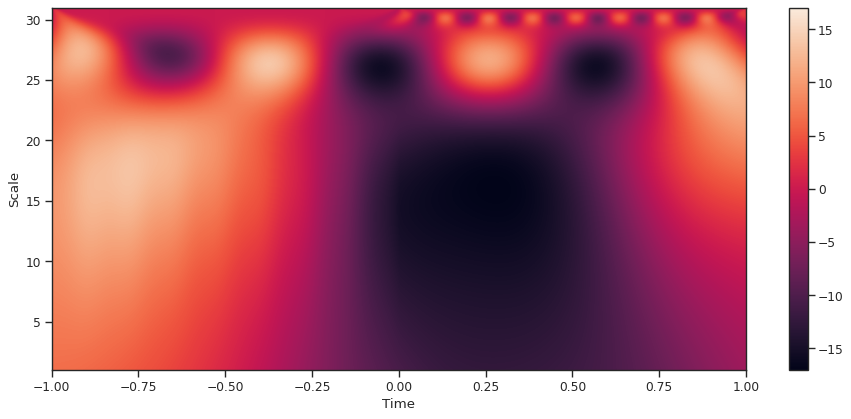

In [31]:
from scipy import signal

t = np.linspace(0, 20, 1000)
x = np.cos(t) + np.cos(t / 4)
y = np.hstack([np.zeros(500), np.cos(5 * t[500:])])

x = x + y
widths = np.arange(1, 501)
# x = values
cwtmatr = signal.cwt(x, signal.ricker, widths)

plt.figure()
plt.plot(t, x)

plt.figure()
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()
plt.ylabel("Scale")
plt.xlabel("Time")

In [32]:
holidays[holidays.description.str.startswith("Navidad")][["date", "description"]]

date description
31  2012-12-21   Navidad-4
33  2012-12-22   Navidad-3
34  2012-12-23   Navidad-2
36  2012-12-24   Navidad-1
37  2012-12-25     Navidad
38  2012-12-26   Navidad+1
84  2013-12-21   Navidad-4
85  2013-12-22   Navidad-3
87  2013-12-23   Navidad-2
88  2013-12-24   Navidad-1
89  2013-12-25     Navidad
90  2013-12-26   Navidad+1
150 2014-12-21   Navidad-4
152 2014-12-22   Navidad-3
153 2014-12-23   Navidad-2
154 2014-12-24   Navidad-1
155 2014-12-25     Navidad
157 2014-12-26   Navidad+1
203 2015-12-21   Navidad-4
204 2015-12-22   Navidad-3
206 2015-12-23   Navidad-2
207 2015-12-24   Navidad-1
208 2015-12-25     Navidad
209 2015-12-26   Navidad+1
289 2016-12-21   Navidad-4
290 2016-12-22   Navidad-3
292 2016-12-23   Navidad-2
293 2016-12-24   Navidad-1
294 2016-12-25     Navidad
295 2016-12-26   Navidad+1
343 2017-12-21   Navidad-4
345 2017-12-22   Navidad-3
346 2017-12-23   Navidad-2
347 2017-12-24   Navidad-1
348 2017-12-25     Navidad
349 2017-12-26   Navidad+1

In [33]:
trs = transactions.merge(
    holidays[holidays.description.str.startswith("Navidad-")][["date", "description"]],
    on="date",
    how="left",
)

trs.description = trs.description.apply(lambda x: int(x.split('-')[-1]) if isinstance(x, str) else 0)
trs = trs.pivot(index="date", columns="store_nbr", values=["transactions", "description"])

trs["transactions"] = trs["transactions"].interpolate(method='time').fillna(0)
trs["description"] = trs["description"].fillna(0)

trs = trs.swaplevel(axis=1)

<AxesSubplot:xlabel='date'>

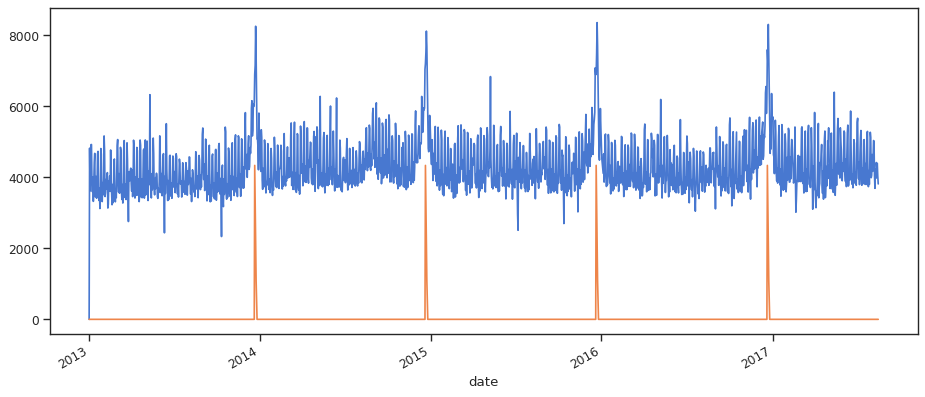

In [34]:
trs[44].transactions.plot()
(trs[44].description * trs[44].transactions.mean() / 4).plot()

In [35]:
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import numpy as np

T = trs[44].asfreq('D').interpolate(method='time')
T

transactions  description
date                                 
2013-01-01           0.0          0.0
2013-01-02        4821.0          0.0
2013-01-03        3618.0          0.0
2013-01-04        4169.0          0.0
2013-01-05        4921.0          0.0
...                  ...          ...
2017-08-11        4418.0          0.0
2017-08-12        4277.0          0.0
2017-08-13        4392.0          0.0
2017-08-14        4039.0          0.0
2017-08-15        3815.0          0.0

[1688 rows x 2 columns]

In [36]:
T["d0"] = T.description
T["d1"] = T.description.shift(periods=-1, fill_value=0)
T

transactions  description   d0   d1
date                                           
2013-01-01           0.0          0.0  0.0  0.0
2013-01-02        4821.0          0.0  0.0  0.0
2013-01-03        3618.0          0.0  0.0  0.0
2013-01-04        4169.0          0.0  0.0  0.0
2013-01-05        4921.0          0.0  0.0  0.0
...                  ...          ...  ...  ...
2017-08-11        4418.0          0.0  0.0  0.0
2017-08-12        4277.0          0.0  0.0  0.0
2017-08-13        4392.0          0.0  0.0  0.0
2017-08-14        4039.0          0.0  0.0  0.0
2017-08-15        3815.0          0.0  0.0  0.0

[1688 rows x 4 columns]

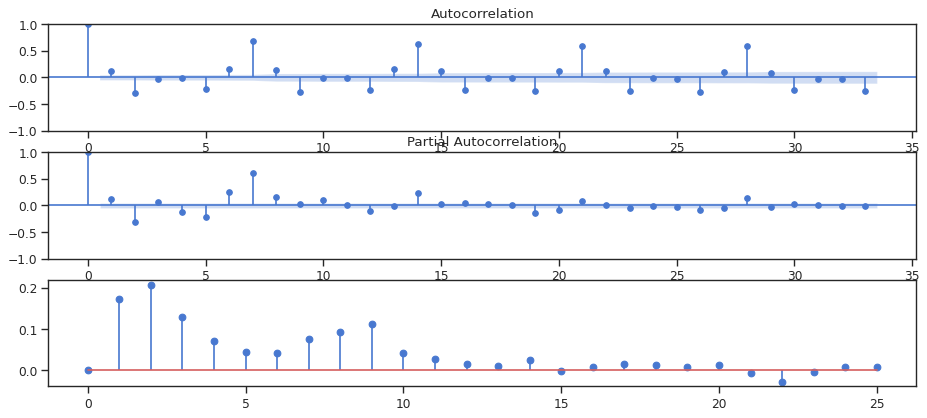

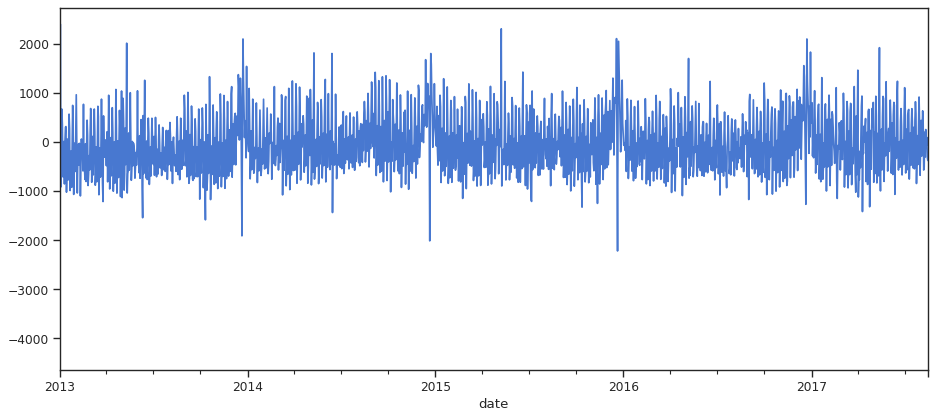

In [37]:
model = ARIMA(T.transactions, exog=T[["d0", "d1"]], order=(1, 0, 0)).fit()

def plot_ccf(x, y, ax):
    c = ccf(x, y)[:26]
    plt.stem(c)

ax = plt.subplot(311); plot_acf(model.resid, ax=ax);
ax = plt.subplot(312); plot_pacf(model.resid, ax=ax, method="ywm");
ax = plt.subplot(313); plot_ccf(model.resid, T.description, ax)
plt.figure(); model.resid.plot();

In [38]:
trs.groupby(["date", "store_nbr"]).mean().unstack().swaplevel(axis=1)[1]

KeyError: 'store_nbr'